In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to(device="cuda")

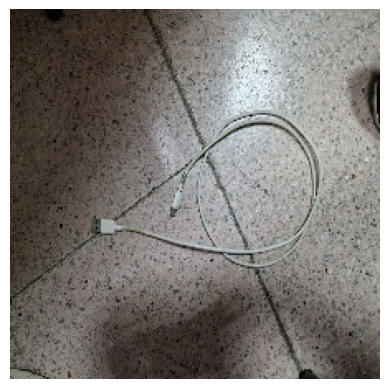

In [63]:

image_path = r'Final_dataset_small2\RAEE\4829_20230330_193454_RAEE_NONE.jpg'.replace('\\', '/')
img_array = cv2.imread(image_path)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array[0]
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
cv2.imwrite('original.jpg', cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR))
plt.imshow(img_array)
plt.axis('off')
plt.show()

In [41]:
mask_generator = SamAutomaticMaskGenerator(sam, stability_score_thresh = 0.1, pred_iou_thresh = 0.1, box_nms_thresh = 0.9)

In [42]:
masks_results = mask_generator.generate(img_array)

In [64]:
from itertools import combinations

masks = [
    mask['segmentation']
    for mask
    in sorted(masks_results, key=lambda x: x['area'], reverse=True) if mask['area'] > 300
]

new_images = []
for mask in masks:
    # new_image es una imagen con todos los pixeles a 127
    new_image = np.full_like(img_array, 0)
    new_image[mask] = img_array[mask]
    new_images.append((new_image, mask))

In [44]:
# Predict the masks
from tensorflow import keras
DIR_MODEL = 'models/xception_fine_no_freeze_flatten.h5'
model = keras.models.load_model(DIR_MODEL)

In [45]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
replace2linear = ReplaceToLinear()
from tf_keras_vis.saliency import Saliency
saliency = Saliency(model,
                    model_modifier=replace2linear)

In [46]:
from tf_keras_vis.layercam import Layercam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

gradcam = Layercam(
    model,
    model_modifier=ReplaceToLinear(),
)

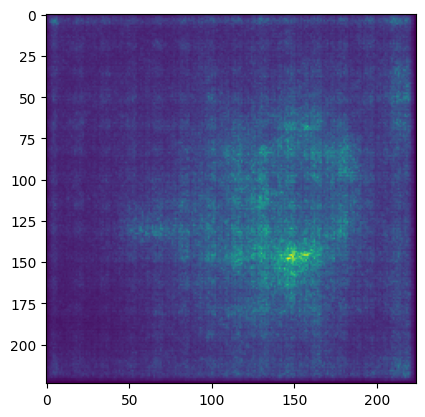

'\nfor img_, mask in new_images:\n    area = np.sum(mask)\n    mask = mask.astype(np.float32)\n    tmp = np.zeros((img_array.shape[0], img_array.shape[1])).astype(np.float32)\n    tmp = saliency_map\n    tmp[saliency_map < saliency_map_mean * 0.5] = -2\n    valor = np.sum((mask * tmp))\n    valid_masks.append((img_, mask, valor))\n\nvalid_masks = sorted(valid_masks, key=lambda x: x[2], reverse=True)\n'

In [65]:
img = img_array.copy()
img = img.astype(np.float32) / 255.0

# Get mask with the highest score compared to the heatmap
valid_masks = []


saliency_map = saliency(CategoricalScore(0), img, smooth_samples=30, smooth_noise=0.2, normalize_map = False)[0]

cv2.imwrite('saliency_map_vanilla.jpg', saliency_map * 255)

plt.imshow(saliency_map)
plt.show()

saliency_map_mean = np.mean(saliency_map)

for img_, mask in new_images:
    area = np.sum(mask)
    mask = mask.astype(np.float32)
    tmp = np.zeros((img_array.shape[0], img_array.shape[1])).astype(np.float32)
    tmp = saliency_map
    tmp[saliency_map < saliency_map_mean * 0.5] = -2
    valor = np.sum((mask * tmp))
    valid_masks.append((img_, mask, valor))

valid_masks = sorted(valid_masks, key=lambda x: x[2], reverse=True)



#for img, mask, valor in valid_masks:
#    print(valor)
#    plt.imshow(mask)
#    plt.show()

c:\Users\Juanma\anaconda3\envs\new-tfg\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


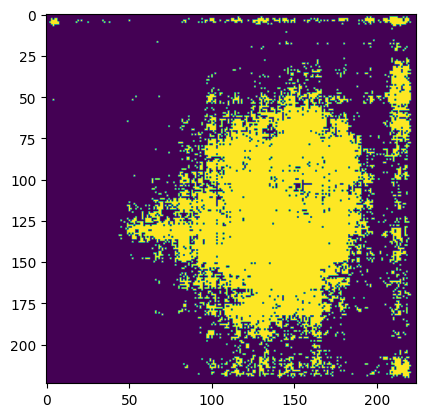

In [66]:
# Kmeans on the saliency map
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

saliency_map2 = saliency_map.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(saliency_map2)

segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(saliency_map.shape)

# Normaliza los valores al rango [0, 255]
scaler = MinMaxScaler(feature_range=(0, 255))
segmented_img = scaler.fit_transform(segmented_img)

# Convertir a enteros para obtener colores válidos
segmented_img = segmented_img.astype(int)

# Show the segmented image
plt.imshow(segmented_img)
plt.show()


9/9 [==============================] - 1s 154ms/step
[0.00810994 0.00430279 0.00643927 0.0027682  0.01902165 0.08032322
 0.27322006 0.13479707 0.02822596 0.30228192 0.15726808 0.00152949
 0.14012098 0.05718821 0.0009947  0.09386712 0.03427373 0.08585231
 0.08108005 0.09670391 0.07135475 0.07272077 0.14043878 0.02844002
 0.19083448 0.0078314  0.01187254 0.13597731 0.10654445 0.09956183
 0.0605275  0.05865306 0.0214399  0.19083008 0.28061152 0.10428118
 0.08838616 0.08946069 0.09943324 0.1580871  0.11265086 0.11474913
 0.14915103 0.09014437 0.08834504 0.06424878 0.16674629 0.05168554
 0.15230384 0.04304012 0.11156102 0.02315948 0.08291052 0.04851859
 0.02673391 0.16348314 0.08271305 0.08494222 0.17722246 0.08514628
 0.1234952  0.05118715 0.07876071 0.09665324 0.12281165 0.03189263
 0.10036335 0.14472544 0.2567003  0.0730325  0.02506763 0.1081911
 0.09133289 0.09259955 0.05340366 0.14153928 0.09564402 0.04225784
 0.04042839 0.10816661 0.09161157 0.08332543 0.17528634 0.14352451
 0.2949594

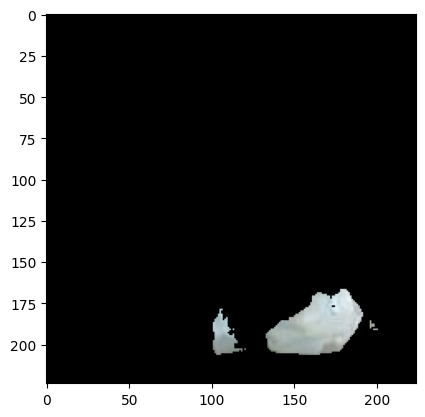

True

In [140]:
CLASS = 0

valid_images = [img for img, _, _ in valid_masks]
values = np.array([value for _, _, value in valid_masks])
valid_images = np.array(valid_images)

new_images_ = valid_images
new_images_ = new_images_.astype('float32') / 255.0
preds = model.predict(new_images_)[:, CLASS]
preds = preds

print(preds)

pred = np.argmax(preds)
print(pred)
plt.imshow(valid_images[pred])
plt.show()
cv2.imwrite('pred.jpg', cv2.cvtColor(valid_images[pred], cv2.COLOR_RGB2BGR))